# Constraint Programming (CP)

In [1]:
# Datenzugriff
from configs.config import get_path
import json

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.cp import makespan

In [2]:
# Datei laden
basic_data_path = get_path("data", "basic")
file_path = basic_data_path / "jobshop_instances.json"

with open(file_path, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [3]:
df_production_orders = init.production_orders(df_instance)
df_production_orders 

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
95,9,9,5,M09,76
96,9,9,6,M05,47
97,9,9,7,M03,52
98,9,9,8,M04,90


### Scheduling

In [4]:
# Scheduling
df_schedule = makespan.solve_jssp(df_production_orders, msg=False)
df_schedule


Solver-Informationen:
  Solver-Status    : OPTIMAL
  Makespan         : 930.0
  Best Bound       : 930.0
  Laufzeit         : 2.46 Sekunden


,Job,Operation,Machine,Start,Processing Time,End
0,0,0,M00,119,29,148
1,0,1,M01,445,78,523
2,0,2,M02,523,9,532
3,0,3,M03,532,36,568
4,0,4,M04,570,49,619
...,...,...,...,...,...,...
95,9,5,M09,518,76,594
96,9,6,M05,630,47,677
97,9,7,M03,735,52,787
98,9,8,M04,787,90,877


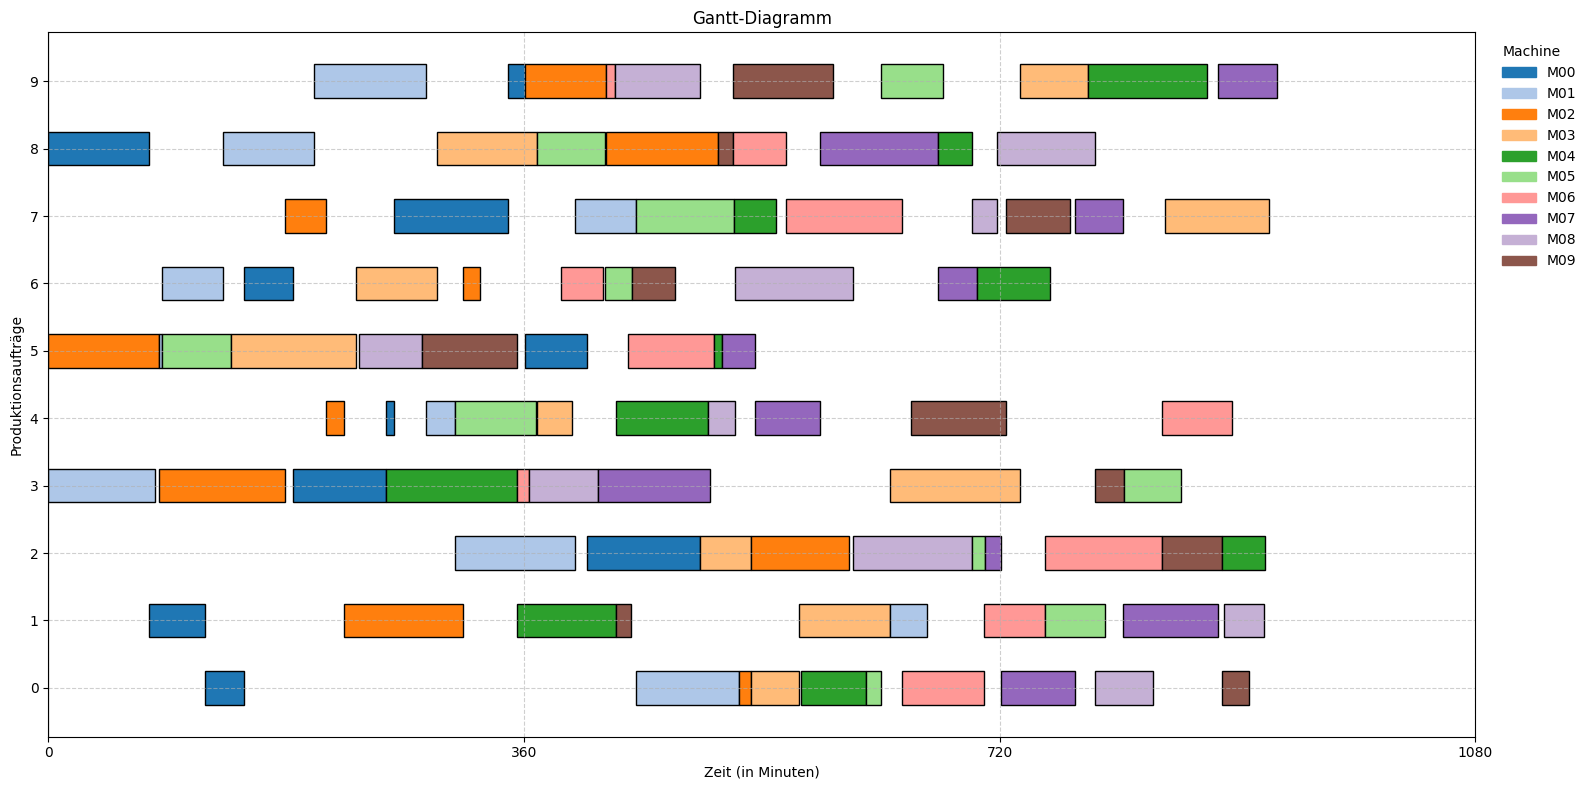

In [5]:
show.plot_gantt(df_schedule, perspective="Job")

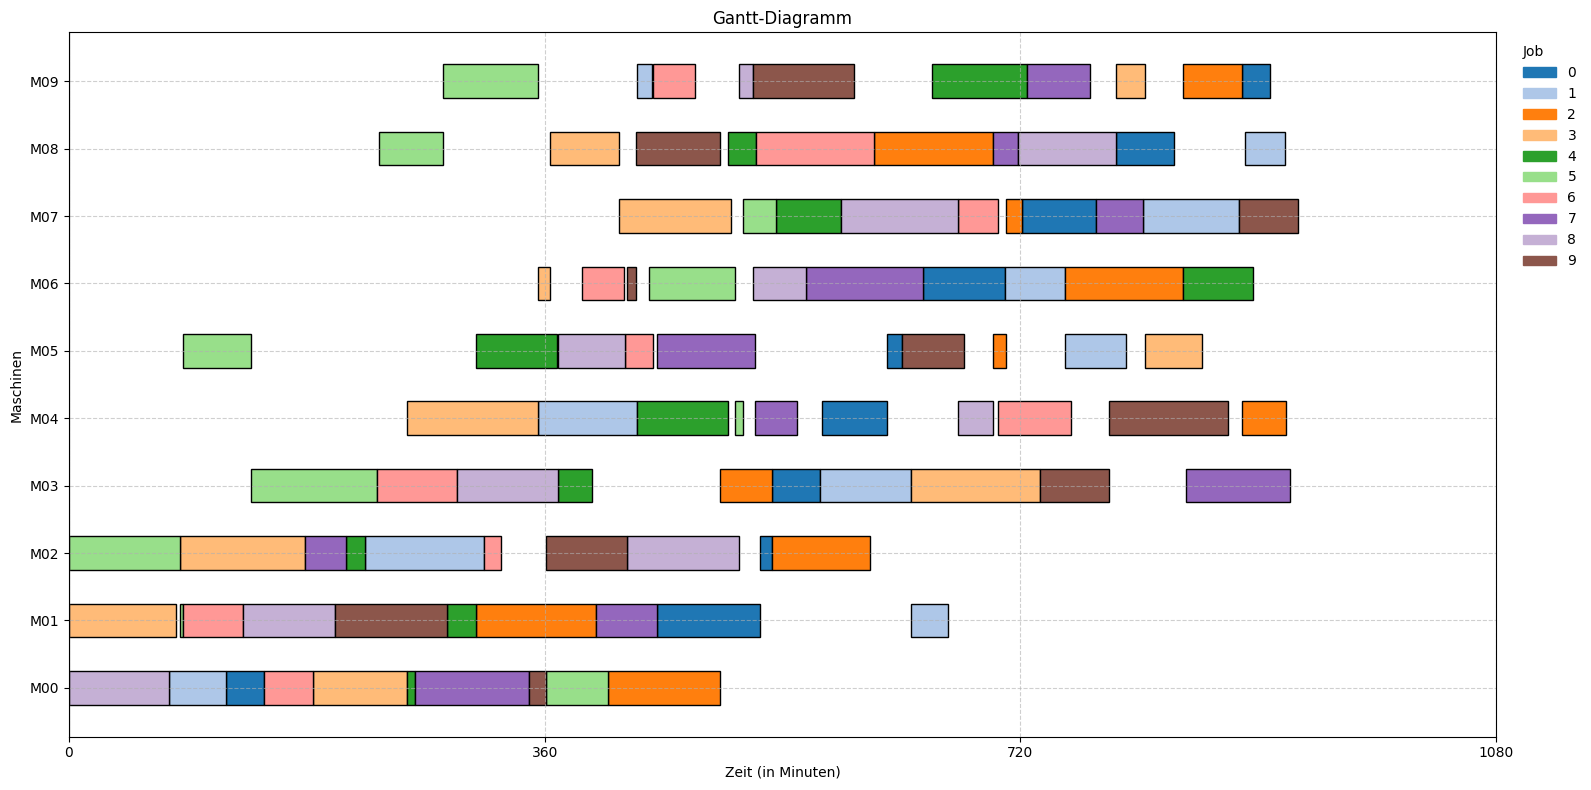

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)